# 个人客户偏好分析

## 业务背景

银行有关部门希望分析个人客户的渠道使用偏好，即通过对客户打上不同的类型标签，进一步有针对性的制定营销策略。

## 数据理解

"PROFILE_BANK"为银行个人客户在一定时期内的业务行为数据
 - 总的业务办理次数即为前四个次数之和

![](image/个人客户业务使用行为数据.png)

除ID外所有的数据都是次数,都可以理解为是连续变量（或有序分类变量）

## 数据探索

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import GridSearchCV

### 读数据

In [2]:
bank_data = pd.read_csv('./data/profile_bank.csv')

### 简单描述

In [3]:
bank_data.head()

,ID,CNT_TBM,CNT_ATM,CNT_POS,CNT_CSC,CNT_TOT
0,41360,34,3,3,9,49
1,52094,44,17,5,18,84
2,57340,122,26,32,36,216
3,76885,42,3,6,1,52
4,89150,20,15,2,2,39


In [4]:
bank_data.describe(percentiles=[0.1, 0.5, 0.75, 0.9]).round()

,ID,CNT_TBM,CNT_ATM,CNT_POS,CNT_CSC,CNT_TOT
count,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,438214630.0,68.0,19.0,12.0,7.0,106.0
std,252612970.0,101.0,21.0,21.0,12.0,113.0
min,41360.0,10.0,3.0,2.0,1.0,17.0
10%,87755189.0,13.0,3.0,2.0,1.0,23.0
50%,439064742.0,52.0,13.0,2.0,2.0,89.0
75%,656785700.0,90.0,29.0,12.0,7.0,143.0
90%,787321491.0,136.0,47.0,36.0,17.0,205.0
max,875674475.0,14934.0,628.0,345.0,607.0,15225.0


- 可以看出每列次数列都有一定程度的右偏
    - 均值大于中位数
    - 分位距变大
- 没有缺失值

查看每列的次数个数（不重复数据个数）

In [5]:
bank_data.nunique()

ID         100000
CNT_TBM       702
CNT_ATM       204
CNT_POS       210
CNT_CSC       171
CNT_TOT       732
dtype: int64

次数个数均较多,作为连续变量处理

In [6]:
bank_data.iloc[:,1:-1].sum()

CNT_TBM    6813696
CNT_ATM    1949971
CNT_POS    1192330
CNT_CSC     668411
dtype: int64

可见:所有人办理业务的总次数沿着:柜台-->ATM-->POS-->有偿 递减

### 可视化

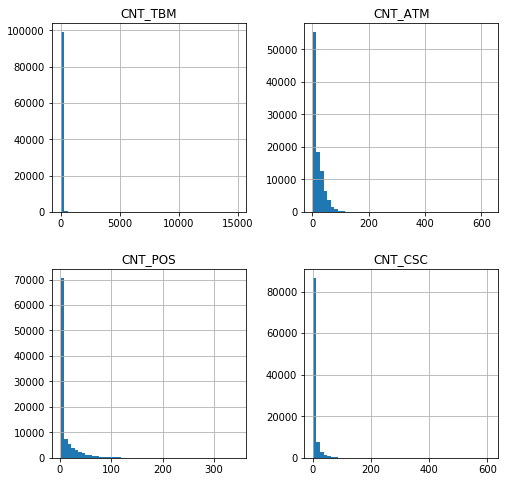

In [7]:
bank_data.hist(column=bank_data.columns[1:-1], 
               bins=50, figsize=(8, 8))
plt.show()

可见:
- 均为比较严重的右偏数据,需要线性变换为偏正态分布

In [8]:
bd_corr = bank_data.iloc[:, 1:-1].corr()
mask = np.zeros_like(bd_corr)
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

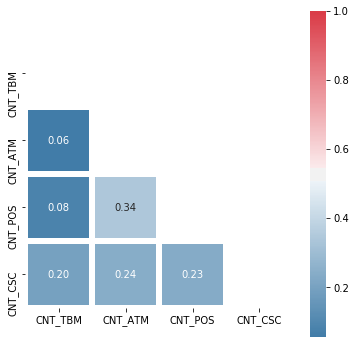

In [9]:
f, ax = plt.subplots(figsize=(6,6))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(bd_corr, mask=mask, square=True,
            cmap=cmap, annot=True, fmt='.2f', linewidth=5)
plt.show()

- sns.heatmap()绘制热图,对应的参数解释如下,[官方文档](https://seaborn.pydata.org/generated/seaborn.heatmap.html):
    - annot: 是否在每个格子中写值
    - square:每个格子是否是正方形
    - mask:True对应的格子不会被显示
    - linewidths:每个格子之间线的宽度
    - cmap:调色板名字或对象
    - fmt:值的格式
- seaborn.diverging_palette()使用两种颜色制作调色板,[官方文档](https://seaborn.pydata.org/generated/seaborn.diverging_palette.html)

可见:
- 次数之间没有明显的两两相关

## 数据预处理

In [10]:
bd = bank_data.iloc[:, 1:-1]

### 标准化

In [11]:
bd_ss = StandardScaler()
bd_pre0 = bd_ss.fit_transform(bd)
print(bd_ss.mean_, bd_ss.var_)

[68.13696 19.49971 11.9233   6.68411] [10232.06124196   434.97257992   429.88769711   147.10048351]


参数: with_mean=True, with_std=True; 结果属性: mean_, var_

In [12]:
bd_X0 = pd.DataFrame(bd_pre0, columns=bd.columns)

In [13]:
bd_X0.head()

,CNT_TBM,CNT_ATM,CNT_POS,CNT_CSC
0,-0.337476,-0.791125,-0.430376,0.190946
1,-0.238617,-0.119856,-0.333915,0.933000
2,0.532487,0.311675,0.968311,2.417108
3,-0.258389,-0.791125,-0.285684,-0.468657
4,-0.475880,-0.215751,-0.478607,-0.386207


### 偏态处理

数据是极度右偏数据,而kmeans对数据的正态性有一定的偏好,故先尝试连续变量的非线性变换查看效果

In [14]:
bd_pt = PowerTransformer(method='box-cox', standardize=True)
bd_pre1 = bd_pt.fit_transform(bd)
print(bd_pt.lambdas_)

[ 0.02021108 -0.06511619 -0.76563362 -0.43354378]


- Method="yeo-johnson",也可以是"box-cox"
- Standardize=True,默认对结果标准化,一般设置为False 
    - 这里设置为True不影响结果查看分布,且为之后的维度归约准备

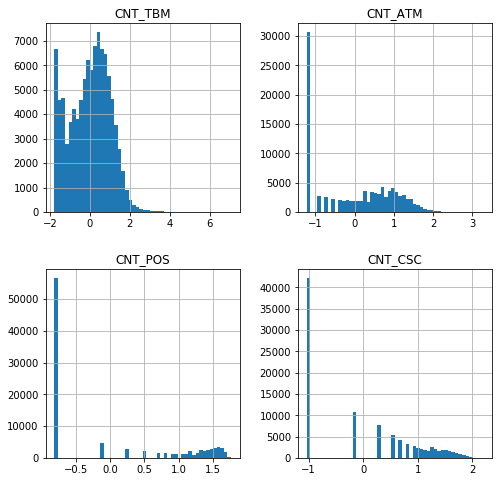

In [15]:
bd_pre1_df = pd.DataFrame(bd_pre1, columns=bd.columns)
bd_pre1_df.hist(column=bd_pre1_df.columns,
               bins=50, figsize=(8, 8))
plt.show()

- 前后对比发现:
    - "CNT_TBM"属性有相对明显的分布变化
    - 其他属性:ATM,POS,有偿服务办理次数由于最小值较多,影响非线性变换后的最终效果
- 总的来说对之前的右偏分布还是有一定改观的,所以这里的数据预处理考虑Box-Cox非线性变换

### 维度压缩

使用主成分分析和因子分析进行降维
- 主成分分析可以查看每个成分的方差解释比例,可以用来确定降到几维
- 因子分析可以得到更具解释性的降维结果

主成分分析

In [16]:
bd_pca = PCA()
bd_pre2 = bd_pca.fit_transform(bd_pre1)

- 参数:
    - n_components: 结果保留的成分数, 没有指定svd算法则默认为列数和行数的较小值
- 结果属性: pca.
    - components_: 成分和原属性的运算表格, 行成分, 列原属性, 按照解释的方差排序
    - explained_variance_: 每个成分解释的方差
    - explained_variance_ratio_：每个成分解释的方差的比例
    - n_components_: 成分个数

查看主成分结果

In [17]:
bd_pca_df = pd.DataFrame(bd_pca.components_,
                         index=['PC' + str(i) for i in range(1, bd_pca.n_components_+1)],
                         columns=bd.columns)
bd_pca_df['explained_var'] = bd_pca.explained_variance_
bd_pca_df['Cumulative_proportion'] = np.cumsum(bd_pca.explained_variance_ratio_)
print(bd_pca_df.round(3))

     CNT_TBM  CNT_ATM  CNT_POS  CNT_CSC  explained_var  Cumulative_proportion
PC1    0.413    0.529    0.555    0.492          2.072                  0.518
PC2    0.711   -0.493   -0.365    0.344          0.889                  0.740
PC3    0.559    0.111    0.187   -0.800          0.614                  0.894
PC4    0.103    0.682   -0.724   -0.003          0.424                  1.000


可见: 2个成分解释74%的信息, 3各成分解释89%的信息,此处可以尝试保留2或3个成分

因子分析

这里尝试了降维到2个和3个成分,发现第3个成分包含很少信息基本没用,所以只保留2个成分

In [18]:
n_com = 2
bd_fa = FactorAnalysis(n_components=n_com, rotation='varimax')
bd_pre3 = bd_fa.fit_transform(bd_pre1)

- 参数:
    - n_components: 结果保留的成分数, 没有指定则默认为列数
    - rotation: 旋转策略,可选'varimax'和'quartimax'
- 结果属性: pca.
    - components_: 成分和原属性的运算表格, 行成分, 列原属性, 按照解释的方差排序

In [19]:
bd_fa_df = pd.DataFrame(bd_fa.components_,
                         index=['FA' + str(i) for i in range(1, n_com+1)],
                         columns=bd.columns)
print(bd_fa_df.round(3))

     CNT_TBM  CNT_ATM  CNT_POS  CNT_CSC
FA1    0.168    0.778    0.694    0.353
FA2    0.641    0.123    0.250    0.475


可见保留的两个因子中:
- FA1: 主要由"CNT_ATM"和"CNT_POS"组成
- FA2: 主要由"CNT_TBM"和"CNT_CSC"组成

故可将降维后的数据列分别命名为: "ATM_POS", "TBM_CSC"

新数据如下:

In [20]:
bd_X = pd.DataFrame(bd_pre3, columns=["ATM_POS", "TBM_CSC"])
bd_X.head()

,ATM_POS,TBM_CSC
0,-0.636036,0.257712
1,0.510962,0.355446
2,1.015260,1.093544
3,-0.479250,-0.187056
4,-0.068486,-0.670984


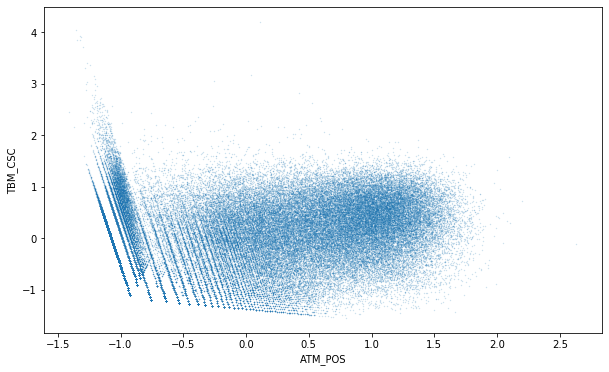

In [21]:
bd_X.plot.scatter(0, 1, alpha=0.3, s=0.1, figsize=(10,6))
plt.show()

## 建模

先对模型聚类,然后使用CART树尝试解释属性到类的规则

### 聚类

#### 选取k值

- 从业务角度上讲,一般将客户分为3-8类
    - 太少难以制定出有针对性的策略
    - 太多制定的策略太复杂
- 从数据中挖掘合理的k值,可以通过尝试不同的k值绘制如下曲线:
    - 绘制对应的误差平方和曲线,通过明显的拐点确定k值
    - 绘制对应的平均轮廓系数曲线,找明显的尖峰,以确定k值

In [22]:
ss = []
sse = []
# 初始化存储轮廓系数的对象ss,存储误差平方和的对象sse
k = list(range(2,9))
# 确定簇中心个数k的取值范围
for i in k:
# 对于每个k值
    bd_km = KMeans(n_clusters=i,random_state=1).fit(bd_X)
    y_pred = bd_km.predict(bd_X)
    ss.append(silhouette_score(bd_X,y_pred))
    # 计算所有样本的平均轮廓系数
    sse.append(bd_km.inertia_)
    # 抽取模型结果中相应的误差平方和

- KMeans参数:
    - n_clusters:簇个数,
    - init:默认"k-means++",初始化的中心点彼此距离尽可能远,会加速收敛防止局部最优;可以是"random"表示随机选择初始中心点,也可以自定义
    - n_init:默认为10,算法使用不同中心点计算的次数,最终结果是表现最好的输出
    - max_iter:每次计算的最大迭代次数,默认100
    - random_state:随机数种子
    - 其他参数[参考](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
- 输出结果包含的属性:
    - cluster_centers:返回聚类中心的坐标
    - labels_:每个点的标签
    - inertia_:每个点到对应簇中心的距离平方和
    - n_iter_:迭代次数
- silhouette_score()计算所有样本点轮廓系数的均值

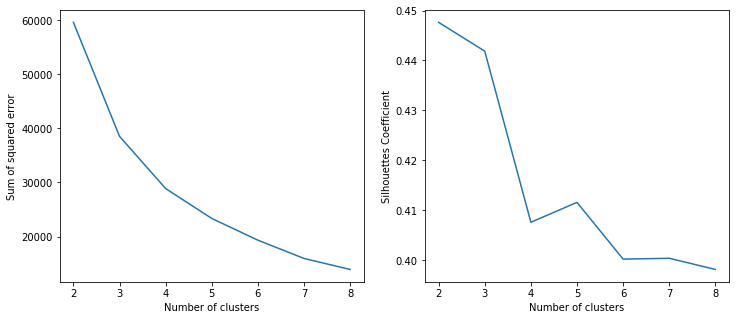

In [23]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(k,sse)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared error")
# 绘制左子图,得到误差平方和图形
plt.subplot(122)
plt.plot(k,ss)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes Coefficient")
# 绘制右子图,得到平均轮廓系数图形
plt.show()

可见:
- 误差平方和图形没有明显的拐点
- 轮廓系数在k=5处有明显的拐点,故此处尝试k=5

#### 依k值聚类

取k为5

In [24]:
bd_km1 = KMeans(n_clusters=5, random_state=1).fit(bd_X)

查看聚类结果,包含聚类中心,聚类簇计数

In [25]:
bd_cc = pd.DataFrame(bd_km1.cluster_centers_,
                     columns=bd_X.columns)
bd_lab = pd.Series(bd_km1.labels_, name='label_counts').value_counts(normalize=True)
bd_cc_lab = pd.concat([bd_cc, bd_lab], 1)
print(bd_cc_lab)

    ATM_POS   TBM_CSC  label_counts
0  1.042720  0.557034       0.23571
1 -0.742416 -0.776875       0.24881
2  0.071634  0.357855       0.17819
3  0.592774 -0.554576       0.16273
4 -0.975417  0.506997       0.17456


可视化聚类结果

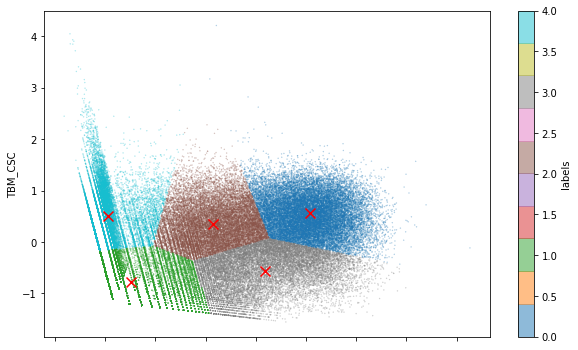

In [26]:
bd_X['labels'] = bd_km1.labels_
bd_X.plot.scatter(0, 1, c='labels', alpha=0.5, 
                  s=0.1, colormap='tab10', figsize=(10, 6))
plt.scatter(bd_cc_lab['ATM_POS'], bd_cc_lab['TBM_CSC'], marker='x',
            s=100, linewidths=3, color='r')
plt.show()

### 使用决策树描述

In [27]:
clf0 = DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.15)
clf0.fit(bd_X.iloc[:, :2], bd_X['labels'])

DecisionTreeClassifier(max_depth=3, min_samples_leaf=0.15)

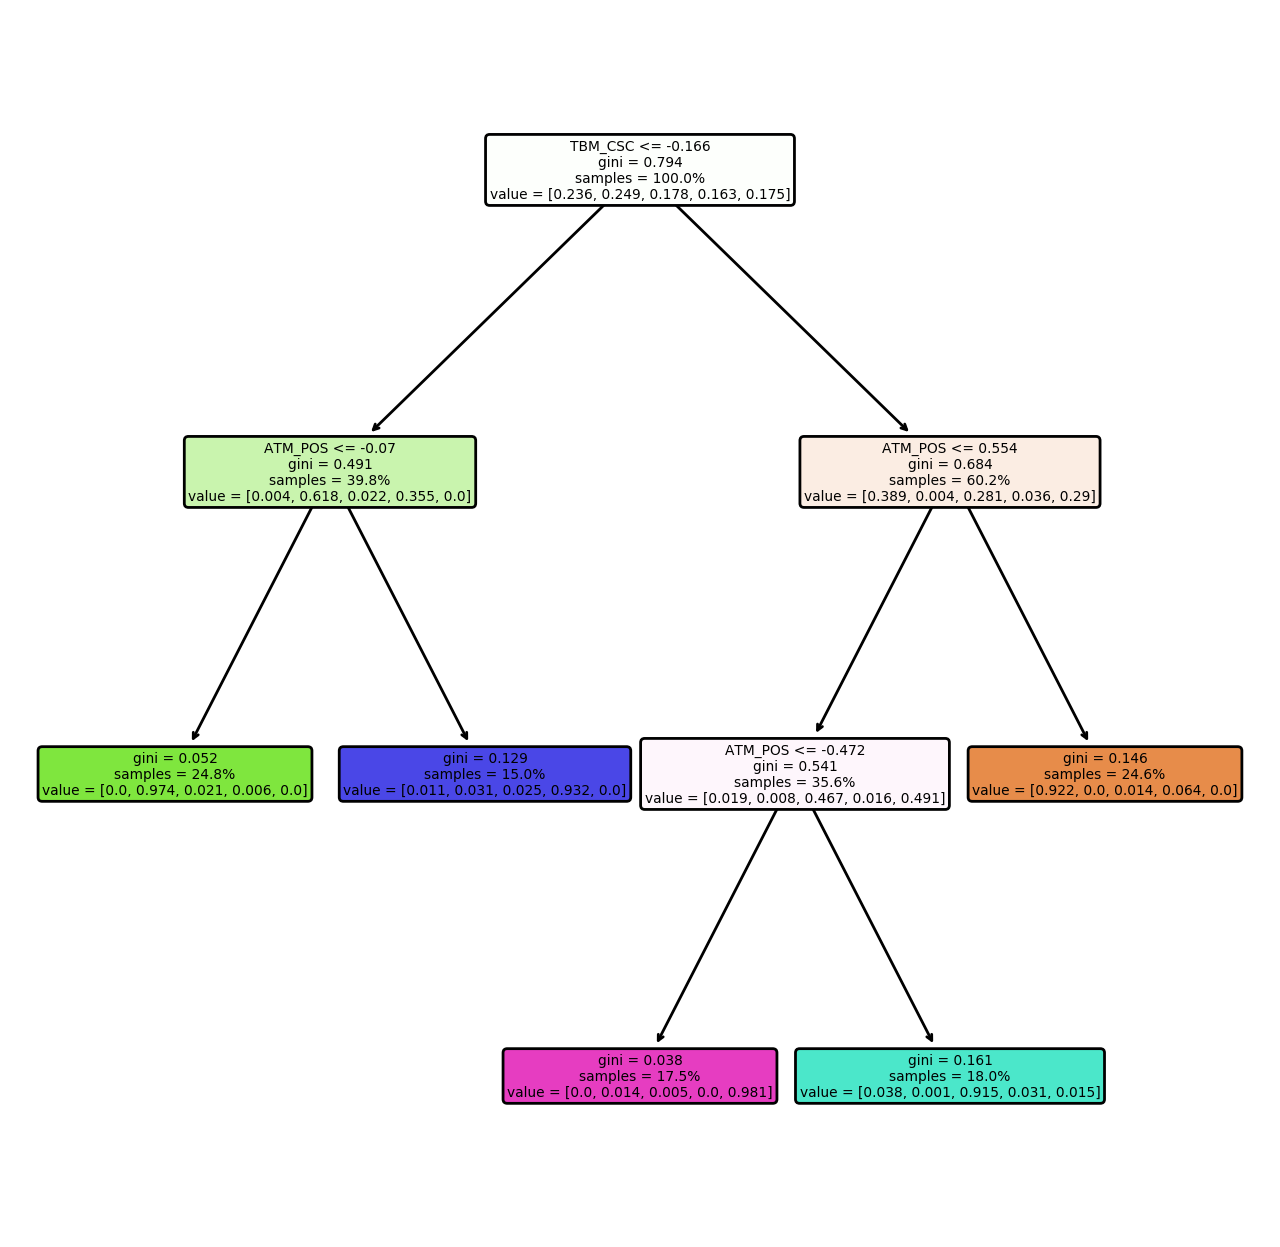

In [28]:
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
plot_tree(clf0, feature_names=bd_X.columns[:2],
          filled=True, rounded=True, proportion=True)
plt.show()

可见:
- TBM_CSC:
    - 柜台办理和有偿服务的的组合,可以理解偏传统,能接受有偿服务,在乎服务品质
    - 被分为两个等级: 低(<=-0.166),高(>-0.166)
- ATM_POS被分为三个等级:
    - ATM办理和POS办理业务的组合,可以理解为喜欢便捷,在乎服务效率
    - 有两种分法:
        - 分为两个等级: 低(<=-0.07),高(>-0.07)
        - 分为三个等级: 较低(<=-0.472),一般((-0.472,0.554]),较高(>0.554)

## 总结

![](image/客户分群业务理解.png)